<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 5: Seasonal ARIMA</h2></center>
<br>

This notebook revisits a seasonal time series to apply seasonal ARIMA.

##### Content:

<a class="buttom" href="#Data:-NSW-Retail-turnover">Data: NSW Retail turnover</a><br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#ARIMA">ARIMA</a><br>
<a class="buttom" href="#Identification" style="margin-left: 10px">(a) Identification</a><br>
<a class="buttom" href="#Automatic-selection" style="margin-left: 10px">(b) Automatic selection</a><br>
<a class="buttom" href="#Estimation" style="margin-left: 10px">(c) Estimation</a><br>
<a class="buttom" href="#Diagnostics" style="margin-left: 10px">(d) Diagnostics</a><br>
<a class="buttom" href="#Exponential-smoothing">Exponential smoothing</a><br>
<a class="buttom" href="#Model-validation">Model validation</a><br>
<a class="buttom" href="#Forecast">Forecast</a><br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook assumes the following packages and settings.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
DATA_FILE = 'datasets/nswretail.csv'
RAW_REPO = 'https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/'
if IN_COLAB:
    DATA_FILE = RAW_REPO + DATA_FILE
    !wget -cO get-x13as.sh {RAW_REPO + 'get-x13as.sh'}
    !sh get-x13as.sh
    !wget -cO plotting.py {RAW_REPO + 'plotting.py'}

In [2]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
# Predefined plots

# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(9,6))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=30, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=30, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

## Data: NSW Retail turnover

In this tutorial we will keep working with the Australian retail turnover series. 

In [5]:
data=pd.read_csv(DATA_FILE, index_col='Month', parse_dates=True, dayfirst=True)
data.index=data.index.to_period()
y=data['Turnover']
data.tail()

,Turnover
Month,
2018-05,8438.3
2018-06,8354.4
2018-07,8304.6
2018-08,8474.8
2018-09,8387.7


We rescale the series to be in millions of rides, to facilitate the intepretation and avoid possible numerical problems.

In [6]:
y=y/(10**3)

As a general rule, you should avoid working with large numbers since they lead to less precise numerical calculations and an accumulation of numerical precision errors. The next cell illustrates this problem. 

In [7]:
x=10**8
for i in range(1000):
    x+=0.001
print(x-10**8)

x=0
for i in range(1000):
    x+=0.001
print(x)

1.0000020265579224
1.0000000000000007


## Exploratory Data Analysis

The next figure shows the time series. 

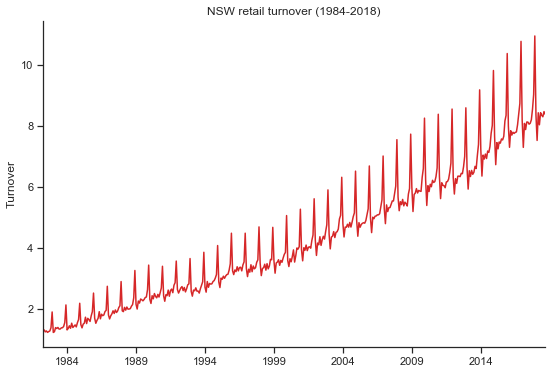

In [8]:
fig, ax= ts_plot(y)
ax.set_ylabel('Turnover')
ax.set_title('NSW retail turnover (1984-2018)')
plt.show()

We conduct a X13-ARIMA-SEATS decomposition for the data again.

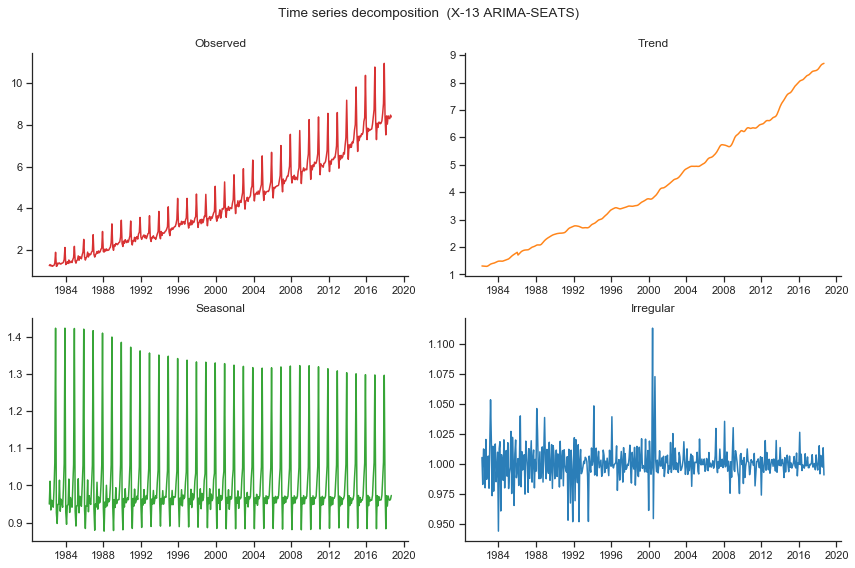

In [9]:
ts=y.copy()
ts.index=pd.to_datetime(ts.index.to_timestamp()) # remember that the decomposition functions only work with datetime
decomposition=sm.tsa.x13_arima_analysis(ts,x12path='.')
seasonal=decomposition.observed/decomposition.seasadj



from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show() 

To better understand the seasonal pattern, the next cell draws a seasonal plot. The turnovers peaks in December.

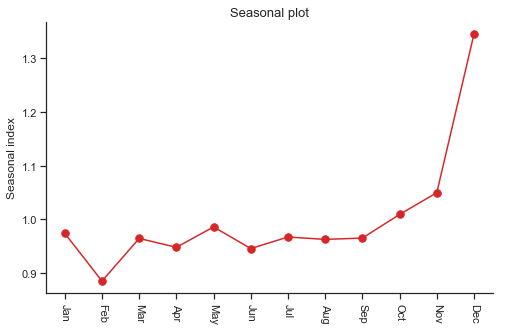

In [10]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(seasonal.groupby(seasonal.index.month).mean(), color=red, marker='.', markersize=15)
ax.set_xlim(0.5,12.5)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months, rotation='-90')
ax.set_ylabel('Seasonal index')
ax.set_title('Seasonal plot', fontsize=13)
sns.despine()
plt.show()

It is useful to save the help X13-ARIMA output for reference. 

In [11]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

## ARIMA



### Identification

To identify an appropriate ARIMA specification for the series, we start by creating a data frame to store the first differenced, seasonally differenced, and first and seasonally differenced series.

In [12]:
df=pd.DataFrame(y.copy())
df.columns.values[0]='original'
df['first_diff']=y-y.shift(1)
df['seasonal_diff']=y-y.shift(12)
df['diff']=df['first_diff']-df['first_diff'].shift(12)
df=df.dropna()

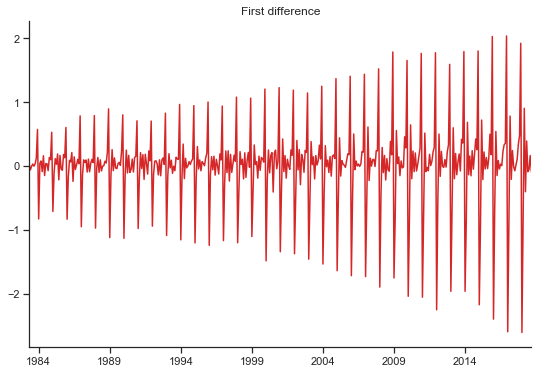

In [13]:
ts_plot(df['first_diff'])
plt.title('First difference')
plt.show()

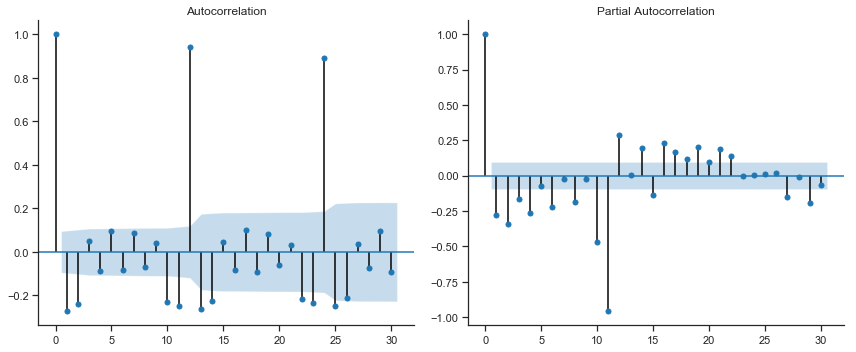

In [14]:
acf_pacf_plot(df['first_diff'])
plt.show()

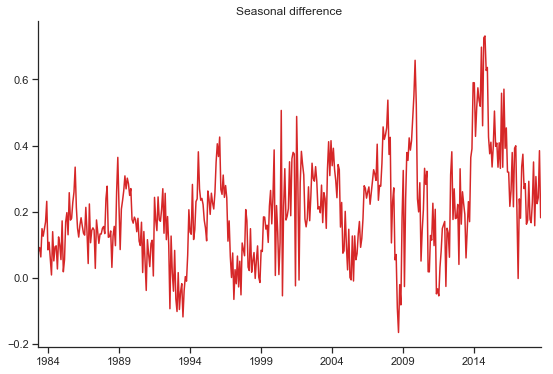

In [15]:
ts_plot(df['seasonal_diff'])
plt.title('Seasonal difference')
plt.show()

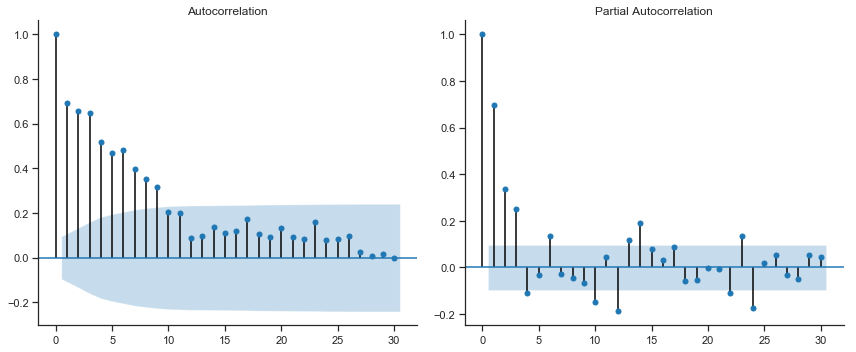

In [16]:
acf_pacf_plot(df['seasonal_diff'])
plt.show()

The next figure shows the first and seasonally differenced series, followed by the ACF and PACF plots.

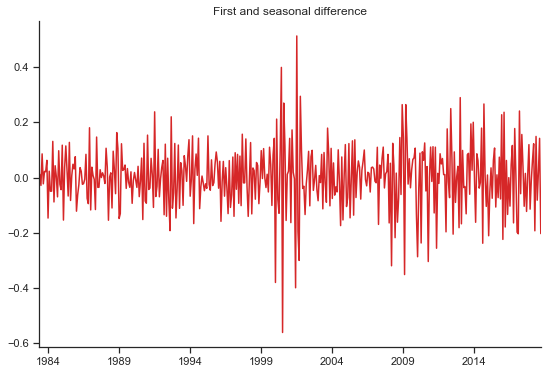

In [17]:
ts_plot(df['diff']) # first and seasonal difference
plt.title('First and seasonal difference')
plt.show()

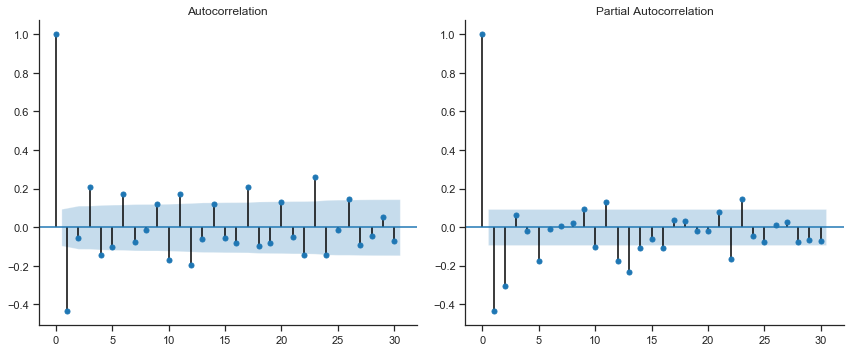

In [18]:
acf_pacf_plot(df['diff'])
plt.show()

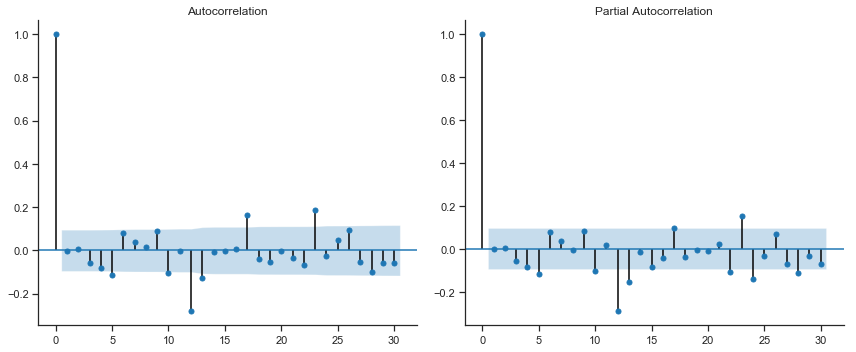

In [19]:
arima = sm.tsa.ARIMA(df['diff'], order=(3, 1, 1)).fit()
acf_pacf_plot(arima.resid)
plt.show()

### Automatic selection

We can also conduct automatic ARIMA order selection based on the X13 ARIMA decomposition software, which is in turn based on the AIC. In practice, it is important to use both the visual and automatic approaches and compare the results. 

In [20]:
results=sm.tsa.x13_arima_select_order(y,x12path='.')
print(results.order) # non-seasonal part
print(results.sorder)# seasonal part

(3, 1, 1)
(0, 1, 1)


## Estimation

In [21]:
sarima=sm.tsa.statespace.SARIMAX(y,  order=results.order, 
                                 seasonal_order=results.sorder + (12,)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Turnover   No. Observations:                  438
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 395.740
Date:                            Fri, 13 Sep 2019   AIC                           -779.480
Time:                                    15:52:16   BIC                           -755.167
Sample:                                04-30-1982   HQIC                          -769.875
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7327      0.613     -1.195      0.232      -1.935       0.469
ar.L2         -0.4054      0.376     -1.079      0.281      -1.142       0.331
ar.L3          0.0119      0.226      0.053      0.958      -0.431       0.455
ma.L1          0.1620      0.608      0.266      0.790      -1.030       1.354
ma.S.L12      -0.3652      0.039     -9.354      0.000      -0.442      -0.289
sigma2         0.0090      0.000     18.355      0.000       0.008       0.010
===================================================================================
Ljung-Box (Q):                      108.16   Jarque-Bera (JB):                35.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostics


In [22]:
resid=sarima.resid[13:] # the first 13 residuals are inialisation ones

Below are the residual plot, ACF and PACF for the ARIMA(3,1,1)(0,1,1) model. Therea are no apparent patterns in these plots, so that model seems to adequately capture time series dependence in the date.

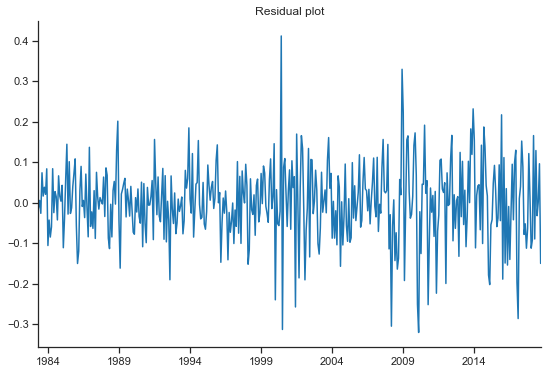

In [23]:
ts_plot(resid, color=blue)
plt.title('Residual plot')
plt.show()

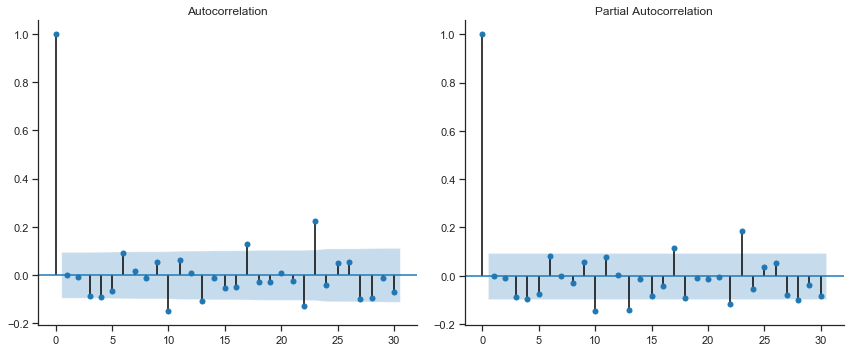

In [24]:
acf_pacf_plot(resid)
plt.show()

The histogram of the residuals is consistent with a normal or near normal distribution.

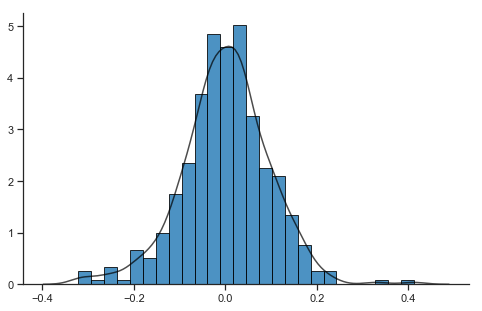

In [25]:
hist(resid)
plt.show()

## Model validation

We now use real-time forecasting (2011 onwards, using full years for around 20% of the data), to confirm whether we should prefer the ARIMA model over the methods, and to estimate how it may perform for short and medium run forecasts. We consider forecasts one month and one year ahead. 

The results clearly show that the ARIMA(3,1,1)(0,1,1) model outperforms exponential smoothing for long forecasting. 

In [26]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2011-10', 'M')

In [27]:
# Real time forecasting

validation=y[start_val:].index
start = y.index.get_loc(start_val)

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, 
                                   seasonal='mul', seasonal_periods=12).fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    model = sm.tsa.ExponentialSmoothing(np.log(y.iloc[:i]), trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()
    results.iloc[j,2]=np.exp(model.forecast(1)[0])
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(3, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[0]

/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWa

In [28]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SEM'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SEM
Seasonal RW,0.359,0.018
Holt-Winters,0.100,0.011
Log Holt-Winters,0.101,0.011
Seasonal ARIMA,0.111,0.012


In [29]:
# Real time forecasting  (One year ahead)

validation=y[start_val:].index
start = y.index.get_loc(start_val)

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
    
    train=y.iloc[:i-12+1]
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = sm.tsa.ExponentialSmoothing(train, trend='add', damped=False, 
                                   seasonal='mul', seasonal_periods=12).fit()
    results.iloc[j,1]=model.forecast(12)[-1]
    
    # log holt winters
    model = sm.tsa.ExponentialSmoothing(np.log(train), trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()
    results.iloc[j,2]=np.exp(model.forecast(12)[-1])
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(train,  order=(3, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast(steps=12)[-1]

# The standard error is not valid in this case because the forecast errors are correlated
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,RMSE
Seasonal RW,0.359
Holt-Winters,0.212
Log Holt-Winters,0.201
Seasonal ARIMA,0.200


## Forecast

Here are the final forecasts based on the ARIMA(3,1,1)(0,1,1) model. We predict a continuing increase in the number of turnovers. 

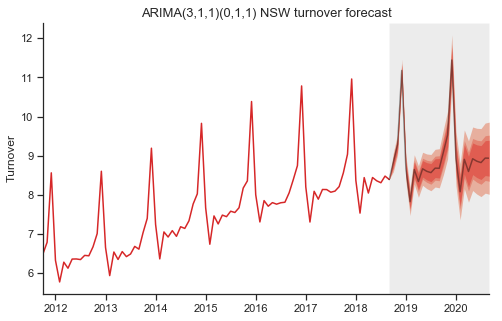

In [30]:
from plotting import fanchart

h=24 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

y_pred = sarima.forecast(steps=h)
y_pred = pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.2)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = fanchart(y[start_val:], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Turnover')
ax.set_title('ARIMA(3,1,1)(0,1,1) NSW turnover forecast', fontsize=13)
sns.despine()
plt.show()